# online market simulator

### part1 : data preparation

In [1]:
from preparation.preparation import load_data,clean_data, summarize_data 

df = load_data("data.xlsx")
df_clean = clean_data(df)
summary = summarize_data(df_clean)
summary.head()
print(summary)

✅ Data loaded successfully! Shape: (525461, 8)
✅ Data cleaned! Remaining rows: 504731
✅ Summary created! 4495 unique products.
                           Description   AvgPrice  TotalQuantity  \
0                *boombox ipod classic  16.980000              1   
1             *usb office glitter lamp   8.650000              1   
2              *usb office mirror ball   8.650000              1   
3               10 colour spaceboy pen   0.980816           6142   
4       11 pc ceramic tea set polkadot   4.950000              3   
...                                ...        ...            ...   
4490      zinc heart lattice tray oval   5.971364            326   
4491       zinc metal heart decoration   1.387674          14120   
4492           zinc police box lantern   7.395000            195   
4493     zinc top  2 door wooden shelf  12.159091            237   
4494  zinc willie winkie  candle stick   1.085273           3950   

      UniqueCustomers  
0                   0  
1       

### part 2 : modeling sellers (you can see seller implementation in modeling package)

### example of sellers and their influencers network

In [2]:
from modeling.seller import Seller, create_sellers_for_product,get_multi_price_products
from random import randint
import pandas as pd

# get top multi price products
top_products = get_multi_price_products(df_clean,2)

# print(top_products)
# Create sellers
all_sellers: dict[str, list[Seller]] = {}

for product in top_products:
    sellers = create_sellers_for_product(df_clean, product)
    all_sellers[product] = sellers

for product, sellers in all_sellers.items():
    influence_scores = {s.name: randint(3, 8) for s in sellers}  # random influence
    for s in sellers:
        s.compute_demand(sellers, influence_scores[s.name])
        s.compute_profit()


results = []
for product, sellers in all_sellers.items():
    for s in sellers:
        results.append(s.info() | {"Product": product})

df_results = pd.DataFrame(results)


df_results


,Seller,Price,Ads,Demand,Profit,Product
0,10 colour spaceboy pen_Seller_1,0.72,9,53.96,14.31,10 colour spaceboy pen
1,10 colour spaceboy pen_Seller_2,0.85,13,53.74,17.20,10 colour spaceboy pen
2,12 ass zinc christmas decorations_Seller_1,2.10,14,54.96,55.24,12 ass zinc christmas decorations
3,12 ass zinc christmas decorations_Seller_2,4.21,15,52.94,163.42,12 ass zinc christmas decorations


### Step 3 — Apply simulation to all product groups

In [3]:
from market.simulation import simulate_nash

final_results = []
all_history = []

for product, sellers in all_sellers.items():
    print(f"Simulating market: {product}")
    final_sellers,history_df = simulate_nash(sellers,max_iterations=100)
    all_history.append(history_df)
    for s in final_sellers:
        final_results.append(s.info() | {"Product": product})

df_final = pd.DataFrame(final_results)
history_all_products = pd.concat(all_history, ignore_index=True)
df_final


Simulating market: 10 colour spaceboy pen
Simulating market: 12 ass zinc christmas decorations


,Seller,Price,Ads,Demand,Profit,Product
0,10 colour spaceboy pen_Seller_1,10.72,-36.0,48.96,546.80,10 colour spaceboy pen
1,10 colour spaceboy pen_Seller_2,10.85,-31.0,50.84,567.92,10 colour spaceboy pen
2,12 ass zinc christmas decorations_Seller_1,12.10,-23.0,51.26,600.13,12 ass zinc christmas decorations
3,12 ass zinc christmas decorations_Seller_2,14.21,-1.0,51.34,687.48,12 ass zinc christmas decorations


plot the simulation iteration

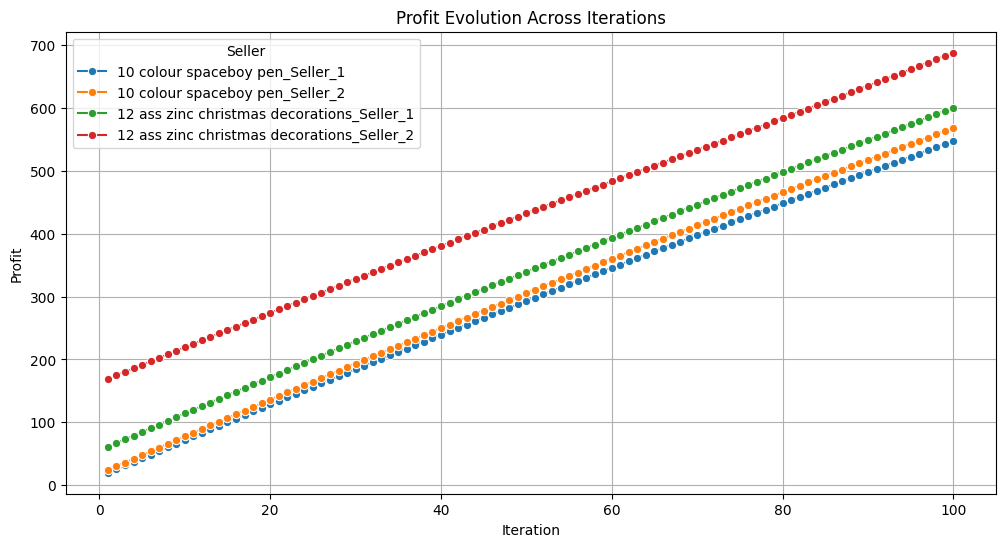

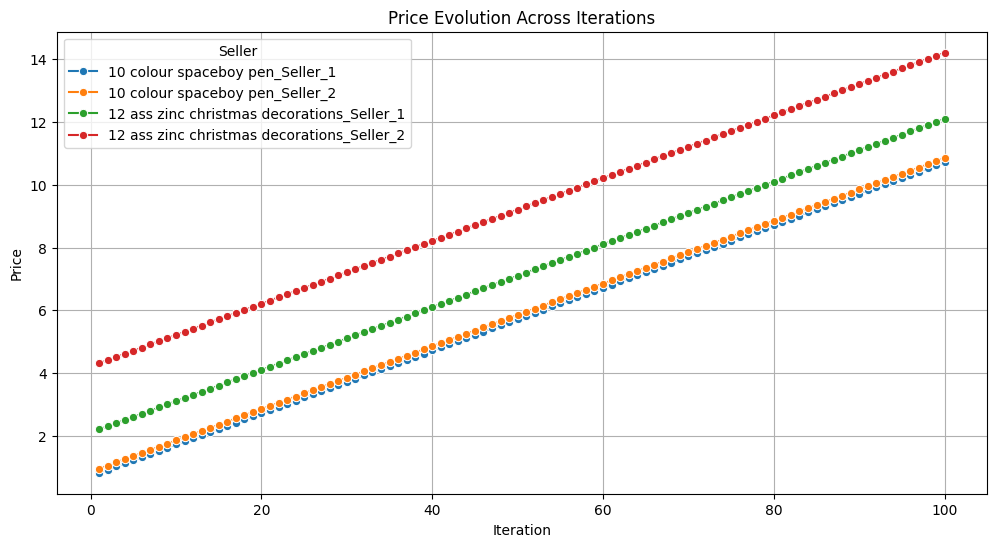

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Plot profit over iterations for each seller
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=history_all_products,
    x="Iteration",
    y="Profit",
    hue="Seller",
    marker="o"
)
plt.title("Profit Evolution Across Iterations")
plt.xlabel("Iteration")
plt.ylabel("Profit")
plt.grid(True)
plt.show()

# You can do the same for Price or AdBudget
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=history_all_products,
    x="Iteration",
    y="Price",
    hue="Seller",
    marker="o"
)
plt.title("Price Evolution Across Iterations")
plt.xlabel("Iteration")
plt.ylabel("Price")
plt.grid(True)
plt.show()


### step4 : influence network

In [5]:
from network.network import (
    build_seller_network,
    compute_network_influence,
    update_sellers_with_network_influence,
)
from market.simulation import simulate_nash
import pandas as pd


#  Build Network

print("Building seller network ...")
G = build_seller_network(all_sellers)


# Compute Influence

print("Computing PageRank-based influence ...")
influence_scores = compute_network_influence(G)
print(influence_scores)

# Update Sellers

print("Updating sellers with network influence ...")
update_sellers_with_network_influence(all_sellers, influence_scores)


# Run Nash Simulation (Network-aware)

print("Running network-aware Nash simulation ...")
network_results = []

for product, sellers in all_sellers.items():
    print(f"\nSimulating {product} with {len(sellers)} sellers ...")
    final_sellers, history_df = simulate_nash(sellers, max_iterations=10000)

    for s in final_sellers:
        network_results.append(s.info() | {"Product": product})

df_network_final = pd.DataFrame(network_results)


# Compare Results

print("\n=== Comparison: Before vs After Network Influence ===")

# Merge on Seller+Product
comparison = pd.merge(
    df_final,
    df_network_final,
    on=["Seller", "Product"],
    how="inner",
    suffixes=("_Before", "_After"),
)

# Compute deltas
comparison["ΔPrice"] = comparison["Price_After"] - comparison["Price_Before"]
comparison["ΔProfit"] = comparison["Profit_After"] - comparison["Profit_Before"]
comparison["ΔDemand"] = comparison["Demand_After"] - comparison["Demand_Before"]

print(comparison[["Seller", "Product", "ΔPrice", "ΔProfit", "ΔDemand"]].head())

# Optional: save to Excel for inspection
comparison.to_excel("network_vs_no_network.xlsx", index=False)
print("\nResults saved to network_vs_no_network.xlsx")


Building seller network ...
Computing PageRank-based influence ...
{'10 colour spaceboy pen_Seller_1': 0.25, '10 colour spaceboy pen_Seller_2': 0.25, '12 ass zinc christmas decorations_Seller_1': 0.25, '12 ass zinc christmas decorations_Seller_2': 0.25}
Updating sellers with network influence ...
Running network-aware Nash simulation ...

Simulating 10 colour spaceboy pen with 2 sellers ...

Simulating 12 ass zinc christmas decorations with 2 sellers ...

=== Comparison: Before vs After Network Influence ===
                                       Seller  \
0             10 colour spaceboy pen_Seller_1   
1             10 colour spaceboy pen_Seller_2   
2  12 ass zinc christmas decorations_Seller_1   
3  12 ass zinc christmas decorations_Seller_2   

                             Product  ΔPrice    ΔProfit  ΔDemand  
0             10 colour spaceboy pen  1000.0  546781.23   497.63  
1             10 colour spaceboy pen  1000.0  547200.07   496.12  
2  12 ass zinc christmas decorations  1

### step 4.1 : visualizing the network 

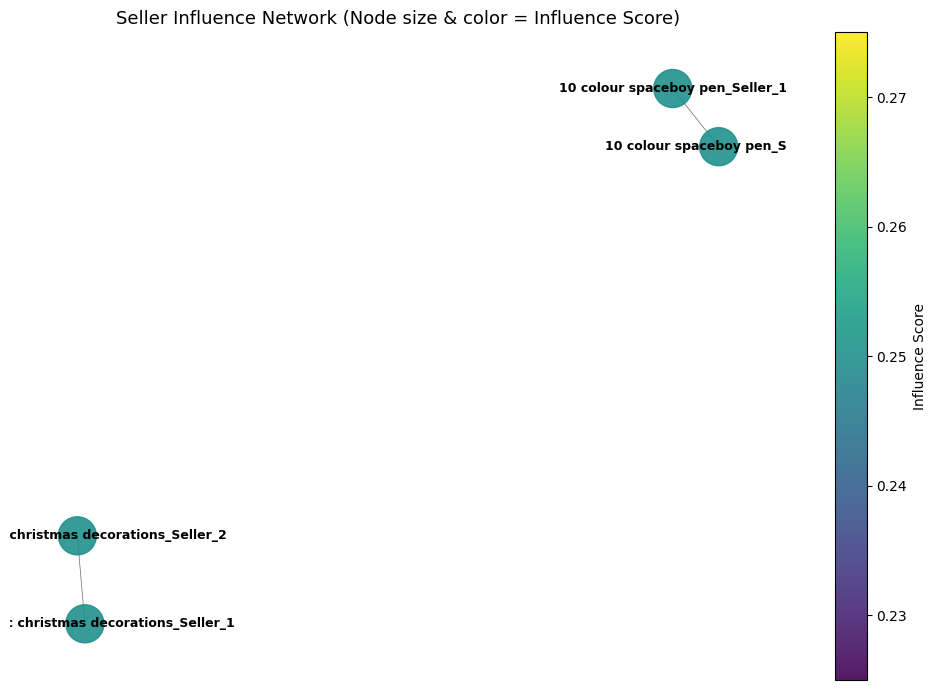

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualize the seller network
plt.figure(figsize=(10, 7))

# Node sizes and colors based on influence
node_sizes = [influence_scores[n] * 3000 for n in G.nodes()]
node_colors = [influence_scores[n] for n in G.nodes()]

pos = nx.spring_layout(G, seed=42, k=0.4)

# Draw graph
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.9
)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

plt.title("Seller Influence Network (Node size & color = Influence Score)", fontsize=13)
plt.axis("off")

# ✅ Properly attach colorbar to the figure
cbar = plt.colorbar(nodes, ax=plt.gca())
cbar.set_label("Influence Score")

plt.tight_layout()
plt.show()


### step5 : visualizing and comparing

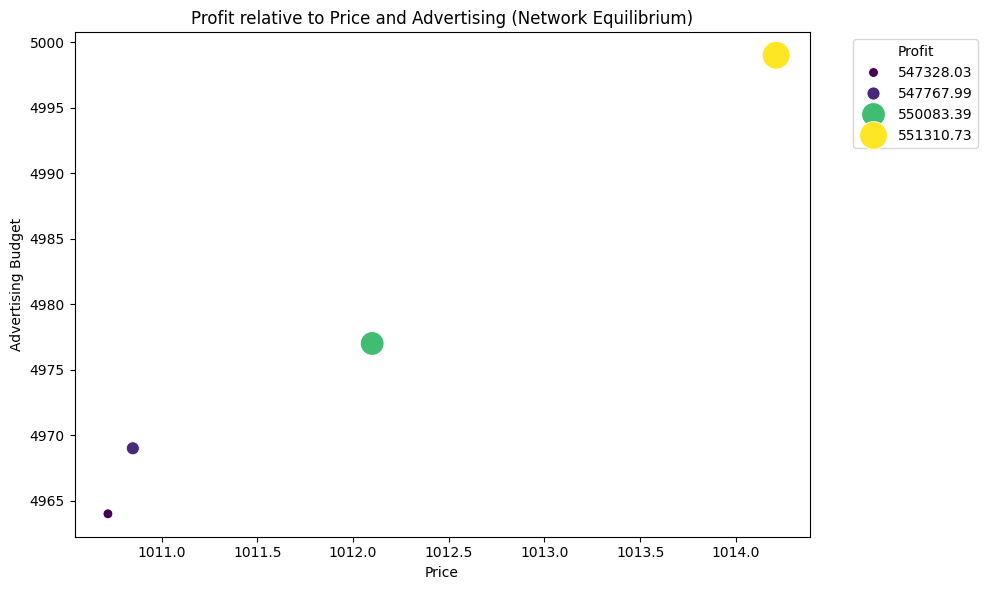

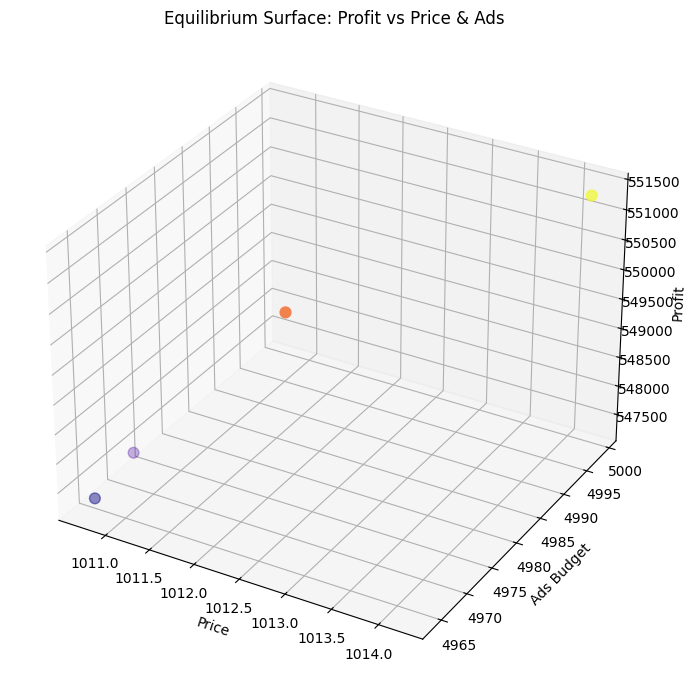

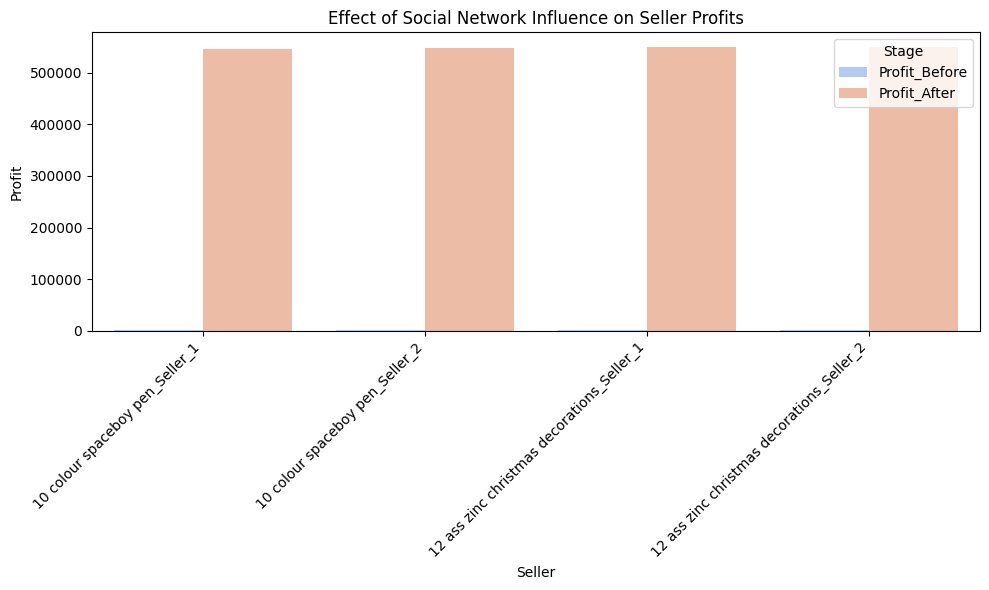

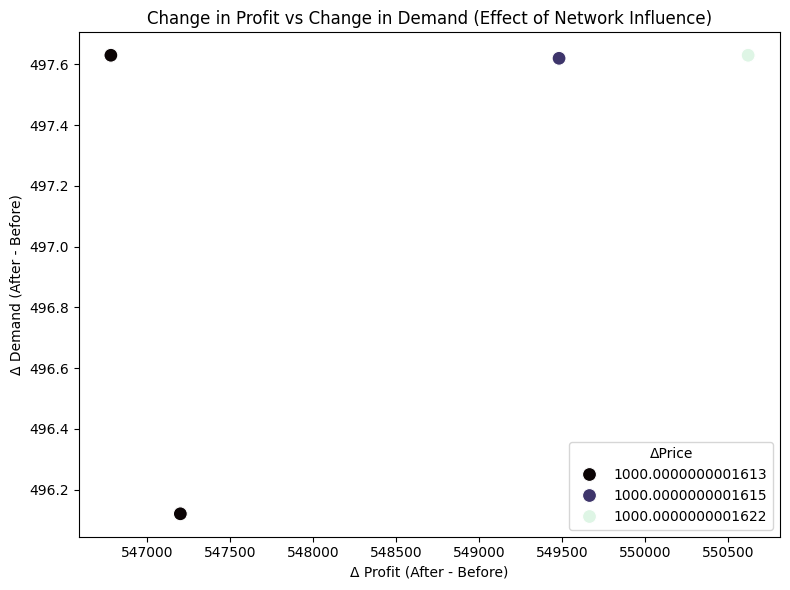

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plot


# 1. Profit vs Price & Ads (2D scatter + 3D surface)


plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_network_final,
    x="Price",
    y="Ads",
    size="Profit",
    hue="Profit",
    palette="viridis",
    sizes=(50, 400)
)
plt.title("Profit relative to Price and Advertising (Network Equilibrium)")
plt.xlabel("Price")
plt.ylabel("Advertising Budget")
plt.legend(title="Profit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 3D visualization of equilibrium
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df_network_final["Price"],
    df_network_final["Ads"],
    df_network_final["Profit"],
    c=df_network_final["Profit"],
    cmap="plasma",
    s=60
)
ax.set_title("Equilibrium Surface: Profit vs Price & Ads")
ax.set_xlabel("Price")
ax.set_ylabel("Ads Budget")
ax.set_zlabel("Profit")
plt.tight_layout()
plt.show()



# 2. Effect of Network Influence (Before vs After)


plt.figure(figsize=(10,6))
sns.barplot(
    data=comparison.melt(
        id_vars=["Seller", "Product"],
        value_vars=["Profit_Before", "Profit_After"],
        var_name="Stage",
        value_name="Profit"
    ),
    x="Seller", y="Profit", hue="Stage", palette="coolwarm"
)
plt.title("Effect of Social Network Influence on Seller Profits")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



# 3. Correlation Plot – ΔProfit vs ΔInfluence (if available)


if "influence_score" in df_network_final.columns:
    influence_dict = df_network_final.set_index("Seller")["Profit"].to_dict()
    comparison["Influence"] = comparison["Seller"].map(influence_dict)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=comparison,
    x="ΔProfit",
    y="ΔDemand",
    hue="ΔPrice",
    palette="mako",
    s=100
)
plt.title("Change in Profit vs Change in Demand (Effect of Network Influence)")
plt.xlabel("Δ Profit (After - Before)")
plt.ylabel("Δ Demand (After - Before)")
plt.tight_layout()
plt.show()
